In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

%matplotlib inline

# Урок 6. Градиентный бустинг. AdaBoost.

**1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

In [21]:
"""функционал ошибки mse"""
mse = lambda y, z: np.mean((y - z)**2)

In [22]:
"""функция потерь L2 loss"""
bias = lambda y, z: y - z

In [28]:
"""предсказание по обученным деревьям"""
def gb_predict(X, trees, coefs, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees, coefs)]) for x in X])

In [104]:
"""обучение модели"""
def gb_fit(n_trees, max_depth, X, y, coefs, eta):
    trees = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        target = np.zeros(shape=y.shape) if len(trees) == 0 else gb_predict(X, trees, coefs, eta)
        tree.fit(X, bias(y, target))
        trees.append(tree)
        
    return trees

In [105]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Зададим начальные коэффициенты $\gamma = 1$, максимальная глубина деревьев 3, шаг градиентного бустинга $\eta = 0.1$. Будем менять число деревьев в ансамбле от 1 до 30.

In [106]:
max_depth = 3
eta = 0.1

train_errors = []
test_errors = []

n_trees_arr = np.arange(1, 31, 1)

for n_trees in n_trees_arr:
    coefs = np.ones(n_trees)
    trees = gb_fit(n_trees, max_depth, X_train, y_train, coefs, eta)

    y_train_pred = gb_predict(X_train, trees, coefs, eta)
    y_test_pred = gb_predict(X_test, trees, coefs, eta)

    train_errors.append(mse(y_train, y_train_pred))
    test_errors.append(mse(y_test, y_test_pred))

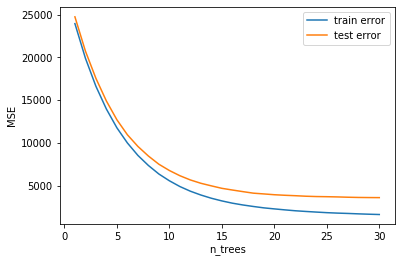

In [107]:
plt.plot(n_trees_arr, train_errors, label='train error')
plt.plot(n_trees_arr, test_errors, label='test error')
plt.xlabel('n_trees')
plt.ylabel('MSE')
plt.legend()
plt.show()

Видим что при увеличении числа деревьев точность модели увеличивается. Переобучение не наступает из-за маленького шага градиентного бустинга. Теперь зададим число деревьев равное 10. Будем менять глубину деревьев от 1 до 30.

In [108]:
n_trees = 10
eta = 0.1
coefs = np.ones(n_trees)

train_errors = []
test_errors = []

max_depth_arr = np.arange(1, 31, 1)

for max_depth in max_depth_arr:
    trees = gb_fit(n_trees, max_depth, X_train, y_train, coefs, eta)

    y_train_pred = gb_predict(X_train, trees, coefs, eta)
    y_test_pred = gb_predict(X_test, trees, coefs, eta)

    train_errors.append(mse(y_train, y_train_pred))
    test_errors.append(mse(y_test, y_test_pred))

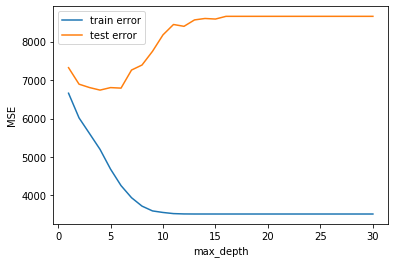

In [113]:
plt.plot(max_depth_arr, train_errors, label='train error')
plt.plot(max_depth_arr, test_errors, label='test error')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

С увеличением глубины деревьев, точность на тиренировочной выборке растёт, а на тестовой в какой-то момент начинает уменьшаться. Модель переобучается.

Для оценки метода градиентного бустинга, найдём `mse` для идеальной модели линейной регрессии, построенной аналитически.

In [114]:
# вектор весов идеальной линейной модели
w = np.linalg.inv((X.T @ X)) @ X.T @ y
w

array([ -10.01219782, -239.81908937,  519.83978679,  324.39042769,
       -792.18416163,  476.74583782,  101.04457032,  177.06417623,
        751.27932109,   67.62538639])

In [115]:
mse(X @ w, y)

26004.287402310347

Получили ошибку `mse = 26004`. Линейные модели не позволяют получить большей точности, эта ошибка обусловлена шумом в исходных данных. При правильном подборе параметров модели градиентного бустинга можно получить гораздо более точный результат, чем при построении модели линейной регрессии.

**2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**